<a href="https://colab.research.google.com/github/MUbarak123-56/cnn-vs-vit/blob/master/ViT_food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ViT Model Training on Food Data

### Package Installation

In [1]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 4.9 MB/s 
     |████████████████████████████████| 115 kB 83.6 MB/s 
     |████████████████████████████████| 212 kB 88.7 MB/s 
     |████████████████████████████████| 163 kB 87.8 MB/s 
     |████████████████████████████████| 127 kB 84.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 4.7 MB/s 
     |████████████████████████████████| 7.6 MB 84.8 MB/s 


### Loading the data

In [22]:
from datasets import load_dataset
food = load_dataset("food101", split="train[:5000]")

In [23]:
food = food.train_test_split(test_size=0.2)
food["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7F199E309AD0>,
 'label': 53}

In [30]:
food["test"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7F199E46DCD0>,
 'label': 81}

In [4]:
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [5]:
labels

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

### Visualizing the data

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

prime_rib
bruschetta
beignets
ramen
chicken_wings
bruschetta
ramen
prime_rib
chicken_wings
ramen


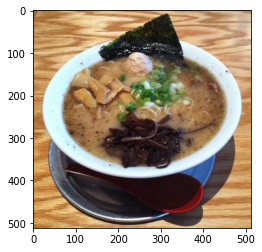

In [7]:
for i in range(10):
  plt.imshow(food["train"][i]["image"])
  print(id2label[str(food["train"][i]["label"])])

In [8]:
id2label[str(79)]

'prime_rib'

### Model Training

In [9]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

In [10]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_transforms = Compose([RandomResizedCrop(feature_extractor.size), ToTensor(), normalize])

In [11]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [12]:
food = food.with_transform(transforms)

In [13]:
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator()

In [14]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=4,
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=feature_extractor,
)

trainer.train()

Using cuda_amp half precision backend
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4000
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1000


Step,Training Loss,Validation Loss
100,0.809100,0.730021
200,0.556100,0.579988
300,0.388700,0.362974
400,0.297200,0.497029
500,0.209200,0.323162
600,0.231400,0.345963
700,0.164300,0.278079


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-100
Configuration saved in ./results/checkpoint-100/config.json
Model weights saved in ./results/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./results/checkpoint-100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/pytorch_model.bin
Feature extractor saved in ./results/checkpoint-200/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-300
Configuration saved in ./results/checkpoint-300/config.json
Model weights saved in ./results/checkpoint-300/pytorch_model.bin
Feature extractor saved in ./results/checkpoint-300/preprocessor_config.json
Deleting older checkpoint

Step,Training Loss,Validation Loss
100,0.809100,0.730021
200,0.556100,0.579988
300,0.388700,0.362974
400,0.297200,0.497029
500,0.209200,0.323162
600,0.231400,0.345963
700,0.164300,0.278079
800,0.077300,0.284120
900,0.110200,0.270492
1000,0.161700,0.260449


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-800
Configuration saved in ./results/checkpoint-800/config.json
Model weights saved in ./results/checkpoint-800/pytorch_model.bin
Feature extractor saved in ./results/checkpoint-800/preprocessor_config.json
Deleting older checkpoint [results/checkpoint-600] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-900
Configuration saved in ./results/checkpoint-900/config.json
Model weights saved in ./results/checkpoint-900/pytorch_model.bin
Feature extractor saved in ./results/checkpoint-900/preprocessor_config.json
Deleting older checkpoint [results/checkpoint-700] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model 

TrainOutput(global_step=1000, training_loss=0.44667706632614135, metrics={'train_runtime': 286.2413, 'train_samples_per_second': 55.897, 'train_steps_per_second': 3.494, 'total_flos': 1.2409719791616e+18, 'train_loss': 0.44667706632614135, 'epoch': 4.0})

### Test set Evaluation

ramen


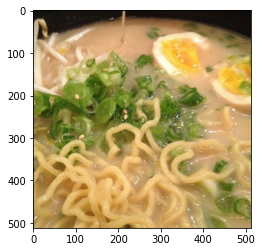

In [33]:
plt.imshow(food["test"][0]["image"])
print(id2label[str(food["test"][i]["label"])])